### This code is for the thesis: "Optimizing Synchrotron Transfer Coefficients with Weighted Sums" 
### by David van Duren

## Import all relevant libraries

In [5]:
import numpy as np
import time
from qpsolvers import solve_qp
from matplotlib import pyplot as plt
import clarabel
from scipy.special import gamma as Gamma
from scipy.special import gammaincc as Gammaincc
from matplotlib.ticker import FuncFormatter
from scipy import sparse
import pandas as pd
from scipy.special import kv
from scipy.special import kn

## Define all electron distribution functions

In [6]:
def f_th(gamma, lam):
    '''
    This is the Maxwell-Jüttner electron distribution function.
    
    gamma = lorentz factor (usually a list)
    lam = 1/theta (where theta is the dimensionaless temperature (usually a list)
    '''
    return ((gamma*np.sqrt(gamma**2 -1))/(2*lam**-3))*np.exp(-gamma*lam)

# Define the target electron distribution f(gamma)(this case the kappa distr. function)
def kappa_dist(gamma, k, w_k):
    """
    This is the kappa distribution function given in your paper. 

    k = kappa(float)
    w_k = width, a parameter of this specific funcion (float)
    gamma = gamma (usually a list)
    theta = theta (dimensionless temperature, usually a list)
    """
    base_func = (((k-2)*(k-1))/((2*k**2)*(w_k**3)))*gamma*np.sqrt(gamma**2 -1)*(((gamma)/(k*w_k))+1)**(-k-1)
    
    return base_func

def kappa_dist_cutoff(gamma,lam_min, k, w_k):
    """
    This is the kappa distribution function given in your paper. 

    k = kappa(float)
    w_k = width, a parameter of this specific funcion (float)
    gamma = gamma (usually a list)
    theta = theta (dimensionless temperature, usually a list)
    lam_min_wk = the cutoff parameter (float)
    """
    lam_min_wk = lam_min*w_k*k
    base_func = ((Gammaincc(1+k, lam_min_wk*((((gamma)/(k*w_k))+1))))/(2*k**3*w_k**3*Gammaincc(k-2, lam_min_wk))) \
                *gamma*np.sqrt(gamma**2 -1)*(((gamma)/(k*w_k))+1)**(-k-1)

    return base_func


## A couple of Maxwell-Juettner distribution functions

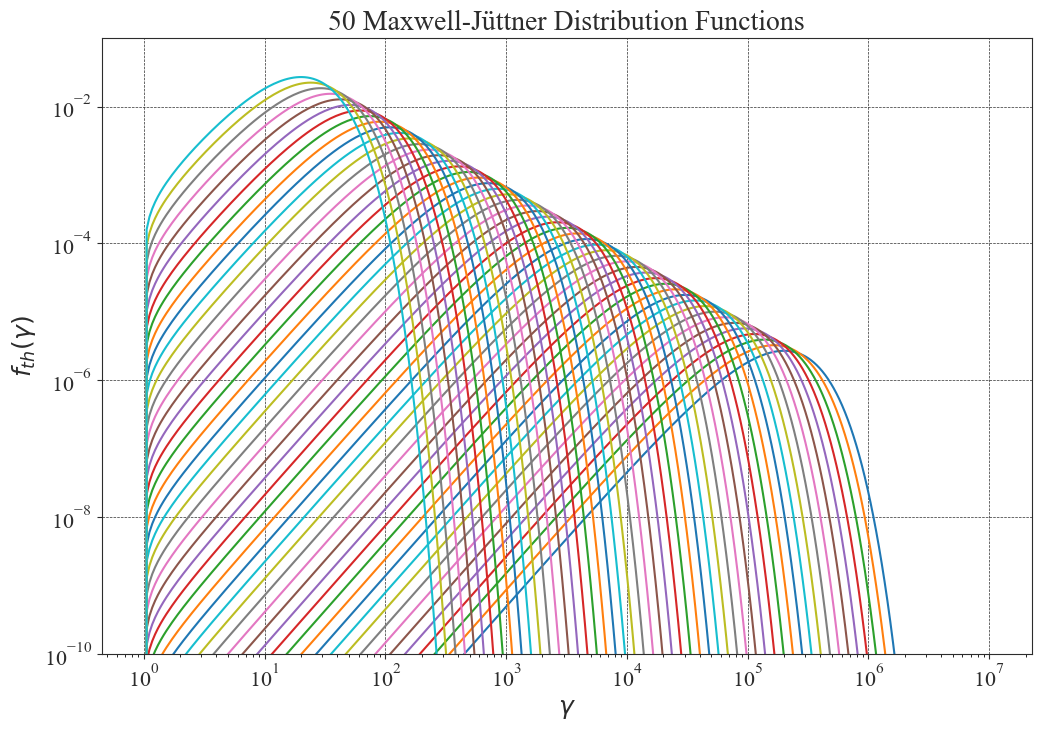

In [8]:
figure, ax = plt.subplots(figsize = (12,8))

"""Set function parameters"""

# Set number of functions
N = 50

# Set lambda values used in MJ function
lam = np.logspace(-5, -1, N)

# Set gamma values used in MJ function
gamma = np.logspace(0,7, 300)

# For loop to plot all N MJ functions
for i in range(N):
    f_i = f_th(gamma, lam[i])
    ax.loglog(gamma, f_th(gamma, lam[i]), label = f'$log(\lambda) = {np.log10(lam[i])}$')
    

"""Set plot layout options """    
ax.grid()

ax.set_facecolor('white')  # Background

# Customize the grid
ax.grid(color='#2c2c2c', linestyle='--', linewidth=0.5)
ax.spines['top'].set_color('#2c2c2c')    # Set the top spine color
ax.spines['bottom'].set_color('#2c2c2c')  # Set the bottom spine color
ax.spines['left'].set_color('#2c2c2c')  # Set the left spine color
ax.spines['right'].set_color('#2c2c2c') # Set the right spine color

ax.set_title(f"{N} Maxwell-Jüttner Distribution Functions", fontsize=20, color='#2c2c2c')  # Font size and color
ax.set_ylabel("$f_{th}(\\gamma)$", fontsize=18, color='#2c2c2c')  # Font size and color
ax.set_xlabel("$\\gamma$", fontsize=18, color='#2c2c2c')  # Font size and color

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=16, colors='#2c2c2c')  # Adjust tick label font size and color

ax.set_ylim(10**-10, 10**-1)


plt.show()

## A couple kappa distribution functions

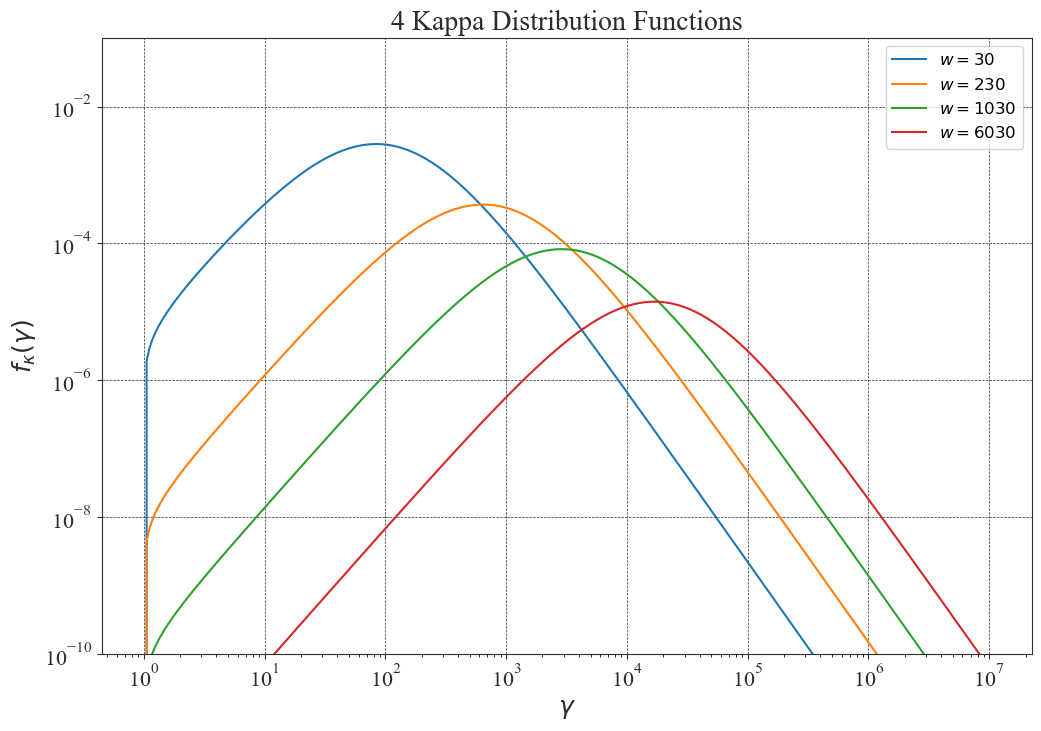

In [4]:
figure, ax = plt.subplots(figsize = (12,8))

"""Set function parameters"""

# Set number of functions
N = 4

# Different kappa parameters for in the kappa function
w_k = [30, 230, 1030, 6030]

# Gamma values for the kappa function
gamma = np.logspace(0,7, 300)

# For loop of all N kappa functions
for i in range(N):
    f_i = kappa_dist(gamma = gamma, k = 3.5, w_k = w_k[i])
    ax.loglog(gamma, f_i, label = f'$w = {w_k[i]}$')

"""Set plot layout options """
ax.grid()
ax.legend(fontsize=12)


# Customize the grid
ax.grid(color='#2c2c2c', linestyle='--', linewidth=0.5)
ax.spines['top'].set_color('#2c2c2c')    # Set the top spine color
ax.spines['bottom'].set_color('#2c2c2c')  # Set the bottom spine color
ax.spines['left'].set_color('#2c2c2c')  # Set the left spine color
ax.spines['right'].set_color('#2c2c2c') # Set the right spine color

ax.set_title(f"{N} Kappa Distribution Functions", fontsize=20, color='#2c2c2c')  # Font size and color
ax.set_ylabel("$f_{\kappa}(\\gamma)$", fontsize=18, color='#2c2c2c')  # Font size and color
ax.set_xlabel("$\\gamma$", fontsize=18, color='#2c2c2c')  # Font size and color

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=16, colors='#2c2c2c')  # Adjust tick label font size and color

ax.set_ylim(10**-10, 10**-1)


plt.show()

## Approximating Kappa electron distr. function

Elapsed time to calculate matrix A: 0.064873 seconds
Elapsed time for b_j: 0.000989 seconds
Elapsed time to calculate weights(incl. QP): 0.003068 seconds for N = 50


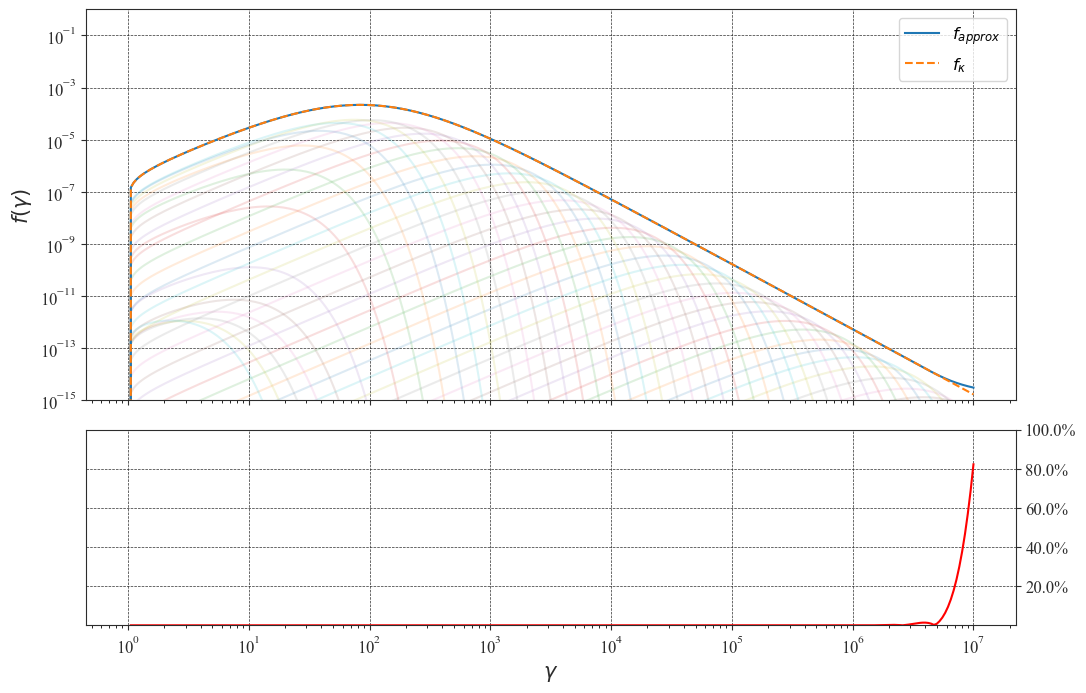

The median error of this approximation is: 8.578467892194976e-06
The max error of this approximation is: 82.32447457566713
The min error of this approximation is: 7.730654661437161e-10


In [13]:
figure, ax = plt.subplots(2,1, figsize = (12,8),sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace':0.1})

# Start the timer
start_time = time.perf_counter()

"""Set function parameters"""

# Set number of thermal components
N = 50

# Set lambda values used in MJ function
lam = np.logspace(-7, 0, N)

# Gamma values for the kappa and MJ functions
gamma = np.logspace(0,7, 300)

# dgamma necessary followed from the derivation in ISE in the thesis
dgam = np.diff(gamma)
dgam = np.append(dgam, dgam[-1])

# Calculate the matrix A
A = np.zeros((N,N))    # Initiate empty matrix
for i in range(N):
    for j in range(N):
        product = f_th(gamma, lam[i])*f_th(gamma, lam[j])*dgam   # For loop over j inside for loop over i
        
        # 'product' produces for every iteration of gamma, so sum is needed to have the entire integral/sum
        A[i, j] = np.sum(product)

# End the timer
end_time = time.perf_counter()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time to calculate matrix A: {elapsed_time:.6f} seconds")


# Start the timer
start_time = time.perf_counter()

# Parameter for the kappa distribution function
w_k = 30
k = 3.5

#In this case lam_min is zero, such that there is no cutoff
lam_min = 0
f_kappa = kappa_dist_cutoff(gamma = gamma, lam_min=lam_min, k=k, w_k=w_k)

f_data = f_kappa


#Computing vector b_j
b = np.zeros(N)           #Start with an empty vector
for i in range(N):
    pro = f_th(gamma, lam[i])*(f_data)*dgam    #f_th*f_k*dgam
    
    # 'Pro' computes for every iteration of gamma, so sum is the whole integral/sum
    b[i] = np.sum(pro)

# End the timer
end_time = time.perf_counter()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time for b_j: {elapsed_time:.6f} seconds")

# Start the timer
start_time = time.perf_counter()

"""Clarabel parameters"""

# Convert A and b into the appropriate matrix form for 

P = sparse.csc_matrix(A) # The matrix in the quadratic term
q = -b  # Linear term (-b because cvxopt solves min 1/2 x^T P x + q^T x)

# Inequality constraints (Gx <= h)
# G is a matrix for enforcing w_i >= 0 (non-negativity constraint)
G = sparse.csc_matrix(-np.identity(N)) # Negative identity matrix to enforce w >= 0
h = np.zeros(N) # Vector of zeros for inequality constraint

cones = [clarabel.NonnegativeConeT(N)]  # Set correct cone to the restriction
settings = clarabel.DefaultSettings()

# Set tolerance to zero, to find best weights possible
settings.tol_gap_abs = 0
settings.tol_gap_rel = 0

# To make sure the program does not go on forever, only allow 100 iterations
settings.max_iter = 100
settings.verbose = False      # Set to true to get more details about what Clarabel computes

"""Clarabel solver"""
solver = clarabel.DefaultSolver(P=P, q=q, A = G, b=h, cones=cones, settings=settings)

solution = solver.solve()

# Solve the quadratic programming problem
sol = np.array(solution.x)
weights = sol

# End the timer
end_time = time.perf_counter()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time to calculate weights(incl. QP): {elapsed_time:.6f} seconds for N = {N}")


"""Compute the approximations"""
f_appr = np.zeros_like(gamma)       # Initiate empty vector

for i, w in zip(range(N), weights):
    # This is the weighted sum and result
    f_i = w*f_th(gamma, lam[i])
    f_appr += f_i
    ax[0].loglog(gamma,w*f_th(gamma, lam[i]), alpha = 0.15)


"""Set plot parameters, and compute plots"""
ax[0].loglog(gamma, f_appr, label='$f_{approx}$')
ax[0].loglog(gamma, f_data,label='$f_{\kappa}$', linestyle = 'dashed')

ax[0].set_ylim(10**-15, 1)
ax[0].set_ylabel("$f(\gamma)$", fontsize=15, color='#2c2c2c')

ax[0].grid()
ax[0].legend(fontsize=12)


figure.patch.set_facecolor('white')  # Background for the figure
ax[0].set_facecolor('white')  # Background for the axes

# Customize the grid
ax[0].grid(color='#2c2c2c', linestyle='--', linewidth=0.5)
ax[0].spines['top'].set_color('#2c2c2c')    # Set the top spine color
ax[0].spines['bottom'].set_color('#2c2c2c')  # Set the bottom spine color
ax[0].spines['left'].set_color('#2c2c2c')  # Set the left spine color
ax[0].spines['right'].set_color('#2c2c2c') # Set the right spine color
# Customize ticks
ax[0].tick_params(axis='both', which='major', labelsize=12, colors='#2c2c2c')  # Adjust tick label font size and color

""""Relative error"""

# Create mask, as sometimes f_data produces zero values
nzmask = f_data != 0

# Compute relative error
rel_error = np.abs((f_data[nzmask]) - f_appr[nzmask]) / (f_data[nzmask]) * 100

ax[1].plot(gamma[nzmask], rel_error, color='red')

ax[1].set_xscale('log')

# Set this paramater to zoom in or out of relative error plot
ax[1].set_ylim(10**-5, 10*10**1)

ax[1].yaxis.set_major_formatter(FuncFormatter(lambda rel_error, _: f'{rel_error:.1f}%'))
ax[1].yaxis.tick_right()

ax[1].set_xlabel("$\gamma$", fontsize=15, color='#2c2c2c')

ax[1].set_facecolor('white')  # Background for the axes

# Customize the grid
ax[1].grid(color='#2c2c2c', linestyle='--', linewidth=0.5)
ax[1].spines['top'].set_color('#2c2c2c')    # Set the top spine color
ax[1].spines['bottom'].set_color('#2c2c2c')  # Set the bottom spine color
ax[1].spines['left'].set_color('#2c2c2c')  # Set the left spine color
ax[1].spines['right'].set_color('#2c2c2c') # Set the right spine color
# Customize ticks
ax[1].tick_params(axis='both', which='major', labelsize=12, colors='#2c2c2c')  # Adjust tick label font size and color
plt.show()

print(f'The median error of this approximation is: {np.median(rel_error)}')
print(f'The max error of this approximation is: {np.max(rel_error)}')
print(f'The min error of this approximation is: {np.min(rel_error)}')

## Approximating 3 Kappa electron distr. function

Elapsed time to calculate matrix A: 0.065139 seconds
Elapsed time for b_j: 0.003788 seconds
Elapsed time to calculate weights(incl. QP): 0.002994 seconds for N = 50


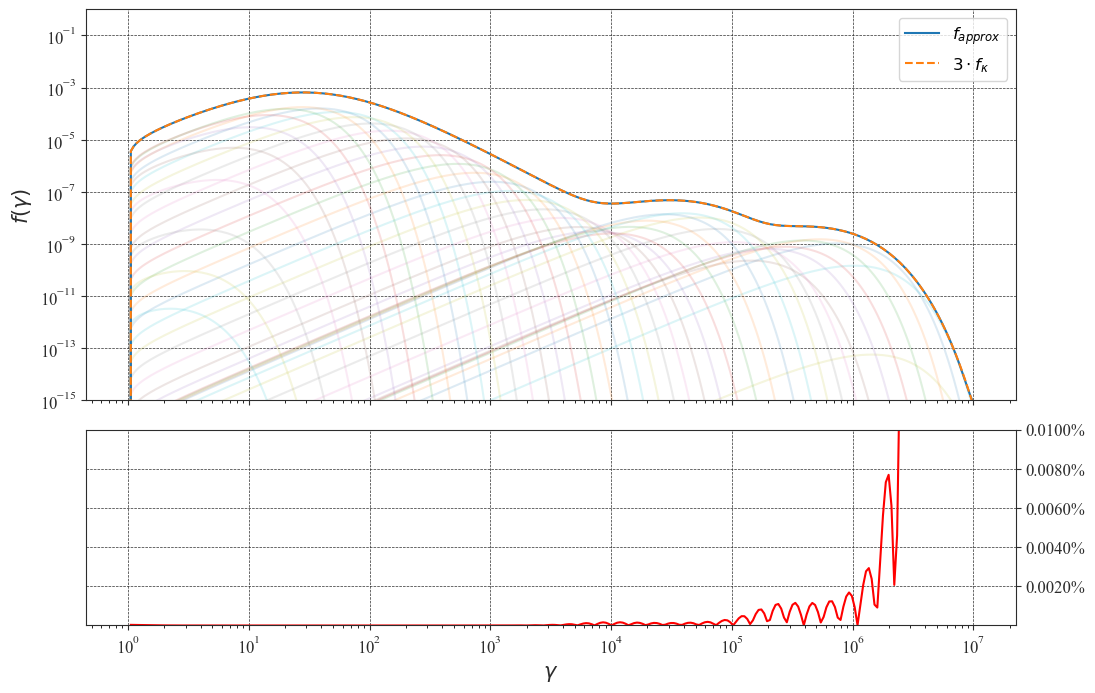

The median error of this approximation is: 1.701777877823993e-05
The max error of this approximation is: 28.736947292977955
The min error of this approximation is: 3.7117012774524548e-09


In [11]:
figure, ax = plt.subplots(2,1, figsize = (12,8),sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace':0.1})

# Start the timer
start_time = time.perf_counter()

"""Set function parameters"""

# Set number of thermal components
N = 50

# Set lambda values used in MJ function
lam = np.logspace(-7, 0, N)

# Gamma values for the kappa and MJ functions
gamma = np.logspace(0,7, 300)

# dgamma necessary followed from the derivation in ISE in the thesis
dgam = np.diff(gamma)
dgam = np.append(dgam, dgam[-1])

#Calculate the matrix A
A = np.zeros((N,N))      # Initiate empty matrix
for i in range(N):
    for j in range(N):
        product = f_th(gamma, lam[i])*f_th(gamma, lam[j])*dgam    # For loop over j inside for loop over i
       
        # 'product' produces for every iteration of gamma, so sum is needed to have the entire integral/sum
        A[i, j] = np.sum(product)

# End the timer
end_time = time.perf_counter()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time to calculate matrix A: {elapsed_time:.6f} seconds")


# Start the timer
start_time = time.perf_counter()

# Parameter for the kappa distribution function
w_k = 10
k = 3.5
lam_min = 10**-3.9     # Set cutoff parameter

# Compute all three kappa distribution function
f_kappa = kappa_dist_cutoff(gamma = gamma, lam_min=lam_min, k=k, w_k=w_k)
f_test = kappa_dist_cutoff(gamma = gamma**0.85, lam_min=lam_min, k=12.5, w_k=3000)
f_test2 = kappa_dist_cutoff(gamma = gamma**0.75, lam_min=lam_min, k=20.5, w_k=30000)

# Sum the kappa functions
f_data = f_kappa + f_test + f_test2


#Computing vector b_j
b = np.zeros(N)                   #Start with an empty vector
for i in range(N):
    pro = f_th(gamma, lam[i])*(f_data)*dgam    #f_th*f_k*dgam
    
    # 'Pro' computes for every iteration of gamma, so sum is the whole integral/sum
    b[i] = np.sum(pro)

# End the timer
end_time = time.perf_counter()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time for b_j: {elapsed_time:.6f} seconds")

# Start the timer
start_time = time.perf_counter()

"""Clarabel parameters"""

# Convert A and b into the appropriate matrix form for cvxopt
P = sparse.csc_matrix(A) # The matrix in the quadratic term
q = -b  # Linear term (-b because cvxopt solves min 1/2 x^T P x + q^T x)

# Inequality constraints (Gx <= h)
# G is a matrix for enforcing w_i >= 0 (non-negativity constraint)
G = sparse.csc_matrix(-np.identity(N)) # Negative identity matrix to enforce w >= 0
h = np.zeros(N) # Vector of zeros for inequality constraint

cones = [clarabel.NonnegativeConeT(N)]   # Select correct cone for the restriction
settings = clarabel.DefaultSettings()

# Set tolerance to zero, to find best weights possible
settings.tol_gap_abs = 0
settings.tol_gap_rel = 0

# To make sure the program does not go on forever, only allow 100 iterations
settings.max_iter = 100
settings.verbose = False        # Set to true to get more details about what Clarabel computes

"""Clarabel solver"""
solver = clarabel.DefaultSolver(P=P, q=q, A = G, b=h, cones=cones, settings=settings)

solution = solver.solve()
# Solve the quadratic programming problem
sol = np.array(solution.x)
weights = sol

# End the timer
end_time = time.perf_counter()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time to calculate weights(incl. QP): {elapsed_time:.6f} seconds for N = {N}")

"""Compute the approximations"""
f_appr = np.zeros_like(gamma)     # Initiate empty vector

for i, w in zip(range(N), weights):
    # This is the weighted sum and result
    f_i = w*f_th(gamma, lam[i])
    f_appr += f_i
    ax[0].loglog(gamma,w*f_th(gamma, lam[i]), alpha = 0.15)


ax[0].loglog(gamma, f_appr, label='$f_{approx}$')
ax[0].loglog(gamma, f_data,label='$3 \cdot f_{\kappa}$', linestyle = 'dashed')

ax[0].set_ylim(10**-15, 1)
ax[0].set_ylabel("$f(\gamma)$", fontsize=15, color='#2c2c2c')

ax[0].grid()
ax[0].legend(fontsize = 12)

figure.patch.set_facecolor('white')  # Background for the figure
ax[0].set_facecolor('white')  # Background for the axes

# Customize the grid
ax[0].grid(color='#2c2c2c', linestyle='--', linewidth=0.5)
ax[0].spines['top'].set_color('#2c2c2c')    # Set the top spine color
ax[0].spines['bottom'].set_color('#2c2c2c')  # Set the bottom spine color
ax[0].spines['left'].set_color('#2c2c2c')  # Set the left spine color
ax[0].spines['right'].set_color('#2c2c2c') # Set the right spine color
# Customize ticks
ax[0].tick_params(axis='both', which='major', labelsize=12, colors='#2c2c2c')  # Adjust tick label font size and color

""""Relative error"""
# Create a mask, because the sum of 3 kappa functions can have zero values
nzmask = f_data != 0

rel_error = np.abs((f_data[nzmask]) - f_appr[nzmask]) / (f_data[nzmask]) * 100

ax[1].plot(gamma[nzmask], rel_error, color='red')
ax[1].set_xscale('log')
ax[1].set_ylim(10**-5, 0.001*10**1)

ax[1].yaxis.set_major_formatter(FuncFormatter(lambda rel_error, _: f'{rel_error:.4f}%'))
ax[1].yaxis.tick_right()

ax[1].set_xlabel("$\gamma$", fontsize=15, color='#2c2c2c')
ax[1].grid()

ax[1].set_facecolor('white')  # Background for the axes

# Customize the grid
ax[1].grid(color='#2c2c2c', linestyle='--', linewidth=0.5)
ax[1].spines['top'].set_color('#2c2c2c')    # Set the top spine color
ax[1].spines['bottom'].set_color('#2c2c2c')  # Set the bottom spine color
ax[1].spines['left'].set_color('#2c2c2c')  # Set the left spine color
ax[1].spines['right'].set_color('#2c2c2c') # Set the right spine color
# Customize ticks
ax[1].tick_params(axis='both', which='major', labelsize=12, colors='#2c2c2c')  # Adjust tick label font size and color

plt.show()

print(f'The median error of this approximation is: {np.median(rel_error)}')
print(f'The max error of this approximation is: {np.max(rel_error)}')
print(f'The min error of this approximation is: {np.min(rel_error)}')

## Comparing method to probability distribution F(lambda)

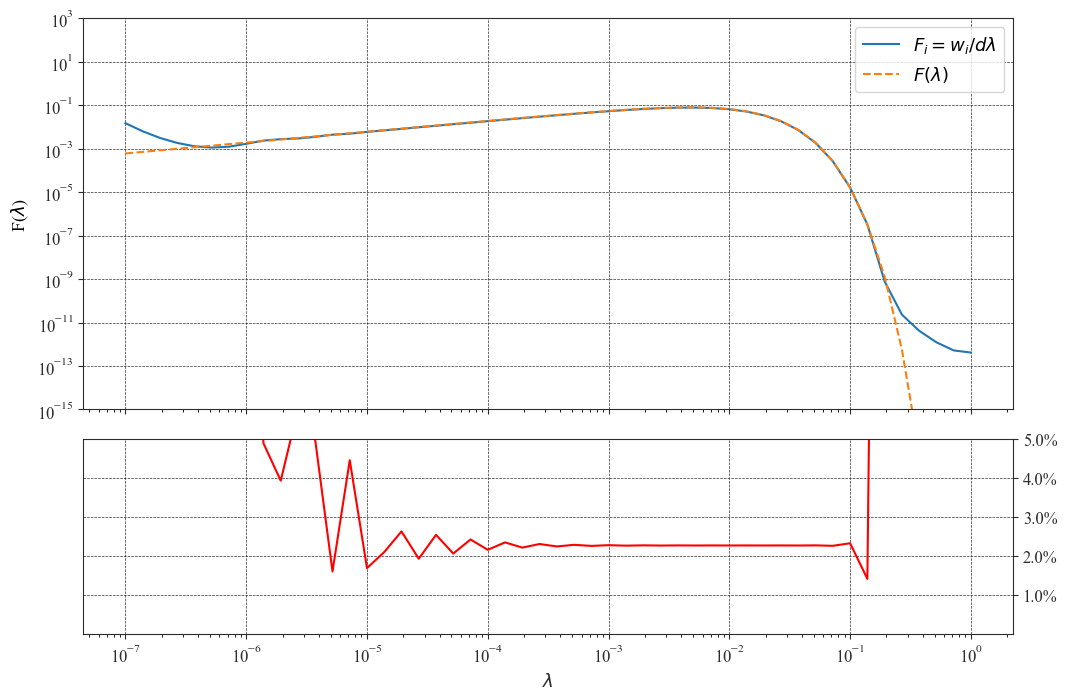

The median difference between these two method: 2.2982256587080423


In [15]:
"""
REFERENCE: 

Móscibrodzka, M. and Gammie, C. F. (2024). 
Stochastic averaging of radiative transfer coefficients for relativistic electrons.
The Astrophysical Journal, 968(1):6.


Note: First compute the approximation for a single kappa distribution function, so you get the correct weights.
"""
figure, ax = plt.subplots(2,1, figsize = (12,8),sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace':0.1})

"""Set parameters"""
# Set lambda values
lam = np.logspace(-7, 0, N)

#Initiate F(lambda) values
f_l_list = []
for l in lam:
    """
    k = kappa parameter
    w_k = width, also kappa parameter
    q and lambda_0 = is stochastic average parameter
    
    """
    k = 3.5
    q = 3-k
    w_k = 30
    
    lambda_0 = (k*w_k)**(-1)
    
    # Probability distribution F(lambda)
    F_lamb =(1 / (lambda_0 * Gamma(1 - q))) * np.exp(-l/ lambda_0)* (lambda_0 / l) ** q

    f_l_list.append(F_lamb)

# Need dlambda to divide the weights by it for the comparison
dlam = np.diff(lam)
dlam = np.append(dlam, dlam[-1])


# Normalize both F(lambda) and the weights
F_lam = f_l_list
F_norm = F_lam/(np.sum(F_lam))

we_lam = weights/dlam
we_norm = we_lam/(np.sum(we_lam))

"""Set plot parameters and compute plots"""

ax[0].plot(lam, we_norm, label=r'$F_i = w_i/d\lambda$')
ax[0].plot(lam, F_norm, label=r'$F(\lambda)$', linestyle = 'dashed')

ax[0].set_ylim(10**(-15), 10**3, )
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[0].set_ylabel("F($\lambda$)", fontsize = 13)
ax[0].legend(fontsize = 13)
ax[0].grid()

"""Compute relative error and plot it"""
rel_error = np.abs((F_norm) - we_norm) / (F_norm) * 100
ax[1].plot(lam, rel_error, color='red')

ax[1].set_xscale('log')
ax[1].set_ylim(10**-5, 0.5*10**1)

ax[1].yaxis.set_major_formatter(FuncFormatter(lambda rel_error, _: f'{rel_error:.1f}%'))
ax[1].yaxis.tick_right()

ax[1].set_xlabel(r'$\lambda$', fontsize=13, color='#2c2c2c')

ax[1].set_facecolor('white')  # Background for the axes

# Customize the grid
ax[0].grid(color='#2c2c2c', linestyle='--', linewidth=0.5)
ax[0].spines['top'].set_color('#2c2c2c')    # Set the top spine color
ax[0].spines['bottom'].set_color('#2c2c2c')  # Set the bottom spine color
ax[0].spines['left'].set_color('#2c2c2c')  # Set the left spine color
ax[0].spines['right'].set_color('#2c2c2c') # Set the right spine color
# Customize ticks
ax[0].tick_params(axis='both', which='major', labelsize=12, colors='#2c2c2c')  # Adjust tick label font size and color

# Customize the grid
ax[1].grid(color='#2c2c2c', linestyle='--', linewidth=0.5)
ax[1].spines['top'].set_color('#2c2c2c')    # Set the top spine color
ax[1].spines['bottom'].set_color('#2c2c2c')  # Set the bottom spine color
ax[1].spines['left'].set_color('#2c2c2c')  # Set the left spine color
ax[1].spines['right'].set_color('#2c2c2c') # Set the right spine color

ax[1].tick_params(axis='both', which='major', labelsize=12, colors='#2c2c2c')  # Adjust tick label font size and color

plt.show()
print(f'The median difference between these two method: {np.median(rel_error)}')

## Emissivities and Absorptivities

In [17]:
"""
REFERENCE:

Thermal emissivity and absorptivity:
Leung, P. K., Gammie, C. F., and Noble, S. C. (2011). 
Numerical calculation of magnetobremsstrahlung emission and absorption coefficients. 
The Astrophysical Journal, 737(1):21.


Kappa emissivity and absorptivity:
Pandya, A., Zhang, Z., Chandra, M., and Gammie, C. F. (2016). 
Polarized synchrotron emissivities and absorptivities for relativistic thermal, power-law, and kappa distribution functions.
The Astrophysical Journal, 822(1):34.


Thermal rotativity:
Dexter, J. (2016). 
A public code for general relativistic, polarised radiative transfer around spinning black holes.
Monthly Notices of the Royal Astronomical Society, 462(1):115–136.
"""
def j_S_th(n_e, freq, freq_c, lam, angle, stokes_param):
    """
    Calculate the synchrotron emissivity of a thermal distribution function.
    
    n_e: the electron distribution function
    freq: frequency in Hz
    freq_c: cyclotron frequency in Hz
    Theta: Temperature dependent function
    Angle: the pitch angle
    Stokes_param: Choose Stokes parameter(I, Q, U, V)
    """
    
    #e = 1.602*10**(-19)
    e = 4.80320680e-10 #CGS units
    c = 2.99792458e10
        
    Theta = 1/lam
    freq_s = (2/9)*freq_c*Theta**2*np.sin(angle)

    X = freq/freq_s
    
    # Compute the selected factor
    if stokes_param == "I":
        stokes_factor = (1/27) * np.sqrt(2) * np.pi * np.sin(angle) * (X**(1/2) + \
                    2**(11/12)*X**(1/6))**2
    elif stokes_param == "Q":
        stokes_factor = -(1/27) * np.sqrt(2) * np.pi * np.sin(angle) * ((X**(1/2) + \
                    2**(11/12)*X**(1/6))**2 * ((7*Theta**(24/25) + 35)/(10*Theta**(24/25) + 75)))**2
    elif stokes_param == "U":
        stokes_factor = 0
    elif stokes_param == "V":
        stokes_factor = - ((37 - 87*np.sin(angle - (28/25)))/(100*(Theta+1))) * \
                    (1 + (Theta**(3.5) / 25 + (7/10)) * X**(9/25))**(5/3)
    else:
        raise ValueError("Invalid Stokes parameter. Choose 'I', 'Q', 'U' or 'V'.")
    
    #The dimensionless emissivity
    J_S_factor = np.exp(-X**(1/3))

    J_S =  J_S_factor * stokes_factor
    
    #Synchtrotron emissivity
    j_S = (n_e) * (e**2) * (freq_c) * (J_S)/c
    
    return j_S

def j_S_kappa(n_e, freq, freq_c, k, w, angle, stokes_param):
    """
    Calculate the synchrotron emissivity of a kappa distribution function.
    
    n_e: the electron distribution function
    freq: frequency in Hz
    freq_c: cyclotron frequency in Hz
    kappa: A number determined by the user (=< 2)
    w: A number determined by the temperature
    Angle: the pitch angle
    Stokes_param: Choose Stokes parameter(I, Q, U, V)
    """
    
    #e = 1.602*10**(-19)
    e = 4.80320680e-10 #CGS units
    c = 2.99792458e10
    freq_k = freq_c * (w*k)**2 * np.sin(angle)
    
    X_k = freq/freq_k
    
    J_S_lo_factor = X_k**(1/3) * np.sin(angle) * ((4*np.pi*(Gamma(k-(4/3))))/(3**(7/3)*Gamma(k-2)))
    
    J_S_hi_factor = X_k**(-(k-2)/2) * np.sin(angle) * 3**((k-1)/2) * ((k-2)*(k-1))/4 * \
                Gamma((k/4) - (1/3))*Gamma((k/4) + (4/3))
    
    # Compute the selected factor
    if stokes_param == "I":
        stokes_lo_factor = 1
        
        stokes_hi_factor = 1
        
        x = 3*(k**(-3/2))
    elif stokes_param == "Q":
        stokes_lo_factor = -1/2
        
        stokes_hi_factor = -((4/5)**2 + (1/50)*k)
        
        x = (37/10)*k**(-8/5)
    elif stokes_param == "U":
        stokes_lo_factor = 0
        
        stokes_hi_factor = 0
        
        x = 0
    elif stokes_param == "V":
        stokes_lo_factor = - (0.75)**2 * (np.sin(angle)**(-12/5) - 1)**(12/25) * \
                        ((k**(-66/125))/w) * X_k**(-7/20)
        
        stokes_hi_factor = -(7/8)**2 * (np.sin(angle)**(-5/2) - 1)**(11/25) * \
                        ((k**(-11/25))/w) * X_k**(-1/2)
        
        x = (13/5)*k**((-6/5)**2)
    else:
        raise ValueError("Invalid Stokes parameter. Choose 'I', 'Q', 'U' or 'V'.")
    
    J_S_bridge = ((J_S_lo_factor**(-x)) + (J_S_hi_factor**(-x)))**(-1/x)
    
    j_S = (n_e) * (e**2) * (freq_c) * (J_S_bridge)/c
    return j_S

def a_S_th(n_e, freq, freq_c, lam, angle, stokes_param):
    """
    Calculate the synchrotron emissivity of a thermal distribution function.
    
    n_e: the electron distribution function
    freq: frequency in Hz
    freq_c: cyclotron frequency in Hz
    Theta: Temperature dependent function
    Angle: the pitch angle
    Stokes_param: Choose Stokes parameter(I, Q, U, V)
    """
    
    #e = 1.602*10**(-19)
    # Constants in CGS units
    e = 4.80320680e-10 
    c = 2.99792458e10
    m_e = 9.1093826e-28
    h = 6.6260693e-27
    
    Theta = 1/lam
    freq_s = (2/9)*freq_c*Theta**2*np.sin(angle)

    X = freq/freq_s
    
    # Compute the selected factor
    if stokes_param == "I":
        stokes_factor = (1/27) * np.sqrt(2) * np.pi * np.sin(angle) * (X**(1/2) + \
                    2**(11/12)*X**(1/6))**2
    elif stokes_param == "Q":
        stokes_factor = -(1/27) * np.sqrt(2) * np.pi * np.sin(angle) * ((X**(1/2) + \
                    2**(11/12)*X**(1/6))**2 * ((7*Theta**(24/25) + 35)/(10*Theta**(24/25) + 75)))**2
    elif stokes_param == "U":
        stokes_factor = 0
    elif stokes_param == "V":
        stokes_factor = - ((37 - 87*np.sin(angle - (28/25)))/(100*(Theta+1))) * \
                    (1 + (Theta**(3.5) / 25 + (7/10)) * X**(9/25))**(5/3)
    else:
        raise ValueError("Invalid Stokes parameter. Choose 'I', 'Q', 'U' or 'V'.")
    
    #The dimensionless emissivity
    J_S_factor = np.exp(-X**(1/3))

    J_S =  J_S_factor * stokes_factor
    
    #The dimensionless absorptivity
    A_S = J_S * ((m_e * c**2 * freq_c)/(2 * h * freq**2)) * (np.exp(((h * freq * lam)/(m_e * c**2))) - 1)
    
    a_S = ((n_e * e**2)/(freq * m_e * c)) * A_S
    return a_S

def rho_Q_th(n_e, freq, freq_c, lam, angle):
        
    #e = 1.602*10**(-19)
    # Constants in CGS units
    e = 4.80320680e-10 
    c = 2.99792458e10
    m_e = 9.1093826e-28
    
    Theta = 1/lam
    freq_s = (2/9)*freq_c*Theta**2*np.sin(angle)

    X = freq/freq_s
    
    f_0 = 2.011*np.exp(-19.78*X**(-0.5175)) - np.cos(39.89*X**(-0.5))*np.exp(-70.16*X**(-0.6)) - 0.011*np.exp(-1.69*X**(-0.5))
    f_m = f_0 + (0.011*np.exp(-1.69*X**-0.5) - 0.003135*X**(4/3)) * (0.5*(1 + np.tanh(10*np.log(0.6648*X**(-0.5)))))
    
    rho_Q_th = - ((n_e * e**2 * freq_c**2 * np.sin(angle)**2)/(m_e * c * freq**3)) * f_m * (kn(1, lam)/kn(2, lam) + 6*Theta)
    
    return rho_Q_th

### Emissivity for approximation of 1 kappa

Elapsed time to calculate weights(incl. QP): 0.000279 seconds for N = 50


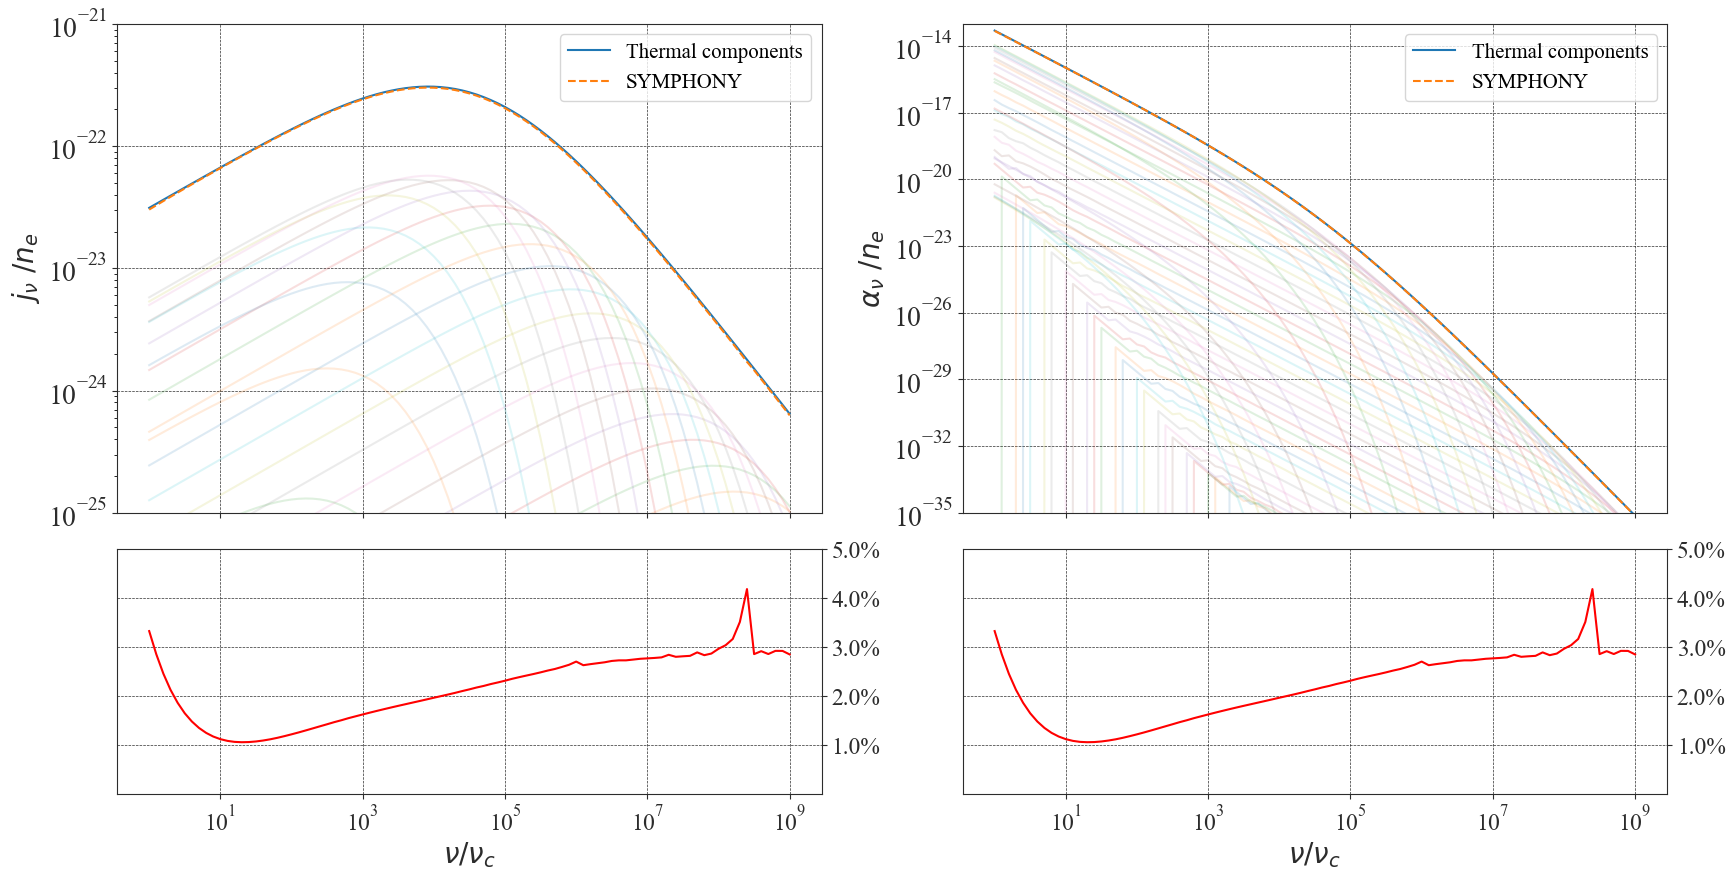

The median error of this approximation is: 2.247391642407051
The max error of this approximation is: 4.189841053420395
The min error of this approximation is: 1.0578115653534326


In [18]:
figure, ax = plt.subplots(2,2, figsize = (20,10),sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Adjust vertical spacing between the plots
figure.subplots_adjust(hspace=0.1)

# Start the timer
start_time = time.perf_counter()

"""Frequencies"""
# Define cyclotron frequency v_c
v_c = 0.84 * 10**8

# Generate the ratio v/v_c = [1, 10, 100, 1000, ...]
ratios = np.logspace(0, 9, 91)  # This will generate [1, 10, 100, 1000, ...,]

# Calculate corresponding frequencies v = v_c * ratio
v = v_c * ratios

"""Lambda values"""
lam = np.logspace(-7, 0, N)

"""Compute emissivity and absorptivity"""
#Weights need to be normalized for computation of transfer coefficients and comparison to Symphony
we_norm = weights/(np.sum(weights))

#Angle (60 Deg)
angle = (1/3)*np.pi

# End the timer
end_time = time.perf_counter()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time to calculate weights(incl. QP): {elapsed_time:.6f} seconds for N = {N}")

#Computes the total emissivity approximation
j_appr = np.zeros_like(v)
for i, w in zip(range(N), we_norm):
    j_i = w*j_S_th(n_e = 1, freq = v, freq_c = v_c, lam = lam[i], angle = angle, stokes_param = "I")
    j_appr += j_i
    ax[0,0].loglog(v/v_c, j_i , alpha = 0.15)

#Computes the total aborptivity approximation
a_appr = np.zeros_like(v)
for i, w in zip(range(N), we_norm):
    a_i = w*a_S_th(n_e = 1, freq = v, freq_c = v_c, lam = lam[i], angle = angle, stokes_param = "I")
    a_appr += a_i
    ax[0,1].loglog(v/v_c, a_i , alpha = 0.15)

"""Symphony"""
# Load the CSV file containing emissivity Symphony data
# Change the path to where this data is contained
file_path = r"Insert your path here"
df = pd.read_csv(file_path)

# Rename columns for easier use
if "nu / nu_c" in df.columns:
    df.rename(columns={"nu / nu_c": "nu/nu_c"}, inplace=True)

#This gets the specific emissivity data from the file
j_symp = df["j_nu"]


# Load the CSV file containing absorptivity Symphony data
# Change the path to where this data is contained
file_path2 = r"Insert your path here"
df2 = pd.read_csv(file_path)

# Rename columns if necessary
if "nu / nu_c" in df.columns:
    df2.rename(columns={"nu / nu_c": "nu/nu_c"}, inplace=True)
a_symp = df["alpha_nu"]

"""Plotting, and plotting parameters"""
#Plot approximation and symphony
ax[0,0].loglog(v/v_c, j_appr, label = 'Thermal components')
ax[0,0].loglog(v/v_c, j_symp, label="SYMPHONY", linestyle = 'dashed')

ax[0,1].loglog(v/v_c, a_appr, label = 'Thermal components')
ax[0,1].loglog(v/v_c, a_symp, label="SYMPHONY", linestyle = 'dashed')


#Set plot parameters
ax[0,0].set_ylim(10**-25, 10**-21)
ax[0,0].set_ylabel(r'$j_{\nu} \ /n_e$', fontsize=20, color='#2c2c2c')
ax[0,0].grid()
ax[0,0].legend(fontsize=15)

ax[0,1].set_ylim(10**-35, 10**-13)
ax[0,1].set_ylabel(r'$\alpha_{\nu} \ /n_e$', fontsize=20, color='#2c2c2c')
ax[0,1].grid()
ax[0,1].legend(fontsize=15)


# Customize the grid
ax[0,0].grid(color='#2c2c2c', linestyle='--', linewidth=0.5)
ax[0,0].spines['top'].set_color('#2c2c2c')    # Set the top spine color
ax[0,0].spines['bottom'].set_color('#2c2c2c')  # Set the bottom spine color
ax[0,0].spines['left'].set_color('#2c2c2c')  # Set the left spine color
ax[0,0].spines['right'].set_color('#2c2c2c') # Set the right spine color
# Customize ticks
ax[0,0].tick_params(axis='both', which='major', labelsize=20, colors='#2c2c2c')  # Adjust tick label font size and color

ax[0,1].grid(color='#2c2c2c', linestyle='--', linewidth=0.5)
ax[0,1].spines['top'].set_color('#2c2c2c')    # Set the top spine color
ax[0,1].spines['bottom'].set_color('#2c2c2c')  # Set the bottom spine color
ax[0,1].spines['left'].set_color('#2c2c2c')  # Set the left spine color
ax[0,1].spines['right'].set_color('#2c2c2c') # Set the right spine color
# Customize ticks
ax[0,1].tick_params(axis='both', which='major', labelsize=20, colors='#2c2c2c')  # Adjust tick label font size and color
# Apply the mask to calculate relative error only where the denominator is non-zero

"""Compute Error and more plotting"""
rel_error = np.abs((j_symp) - j_appr) / (j_symp) * 100
ax[1,0].plot(v/v_c, rel_error, color='red')

ax[1,0].set_xscale('log')
ax[1,0].set_ylim(10**-5, 0.5*10**1)

ax[1,0].yaxis.set_major_formatter(FuncFormatter(lambda rel_error, _: f'{rel_error:.1f}%'))
ax[1,0].yaxis.tick_right()

ax[1,0].set_xlabel(r'$\nu / \nu_c$', fontsize=20, color='#2c2c2c')
ax[1,0].grid()
ax[1,0].set_facecolor('white')  # Background for the axes


rel_error2 = np.abs((j_symp) - j_appr) / (j_symp) * 100
ax[1,1].plot(v/v_c, rel_error2, color='red')

ax[1,1].set_xscale('log')

# Set ylim to zoom in or out of the error plot
ax[1,1].set_ylim(10**-5, 0.5*10**1)

ax[1,1].yaxis.set_major_formatter(FuncFormatter(lambda rel_error, _: f'{rel_error:.1f}%'))
ax[1,1].yaxis.tick_right()

ax[1,1].set_xlabel(r'$\nu / \nu_c$', fontsize=20, color='#2c2c2c')
ax[1,1].grid()

ax[1,1].set_facecolor('white')  # Background for the axes


# Customize the grid
ax[1,0].grid(color='#2c2c2c', linestyle='--', linewidth=0.5)
ax[1,0].spines['top'].set_color('#2c2c2c')    # Set the top spine color
ax[1,0].spines['bottom'].set_color('#2c2c2c')  # Set the bottom spine color
ax[1,0].spines['left'].set_color('#2c2c2c')  # Set the left spine color
ax[1,0].spines['right'].set_color('#2c2c2c') # Set the right spine color
# Customize ticks
ax[1,0].tick_params(axis='both', which='major', labelsize=17, colors='#2c2c2c')  # Adjust tick label font size and color

# Customize the grid
ax[1,1].grid(color='#2c2c2c', linestyle='--', linewidth=0.5)
ax[1,1].spines['top'].set_color('#2c2c2c')    # Set the top spine color
ax[1,1].spines['bottom'].set_color('#2c2c2c')  # Set the bottom spine color
ax[1,1].spines['left'].set_color('#2c2c2c')  # Set the left spine color
ax[1,1].spines['right'].set_color('#2c2c2c') # Set the right spine color
# Customize ticks
ax[1,1].tick_params(axis='both', which='major', labelsize=17, colors='#2c2c2c')  # Adjust tick label font size and color
plt.show()

print(f'The median error of this approximation is: {np.median(rel_error)}')
print(f'The max error of this approximation is: {np.max(rel_error)}')
print(f'The min error of this approximation is: {np.min(rel_error)}')

## Rotativity Q for approximation of 1 kappa

Elapsed time to calculate weights(incl. QP): 0.000413 seconds for N = 20


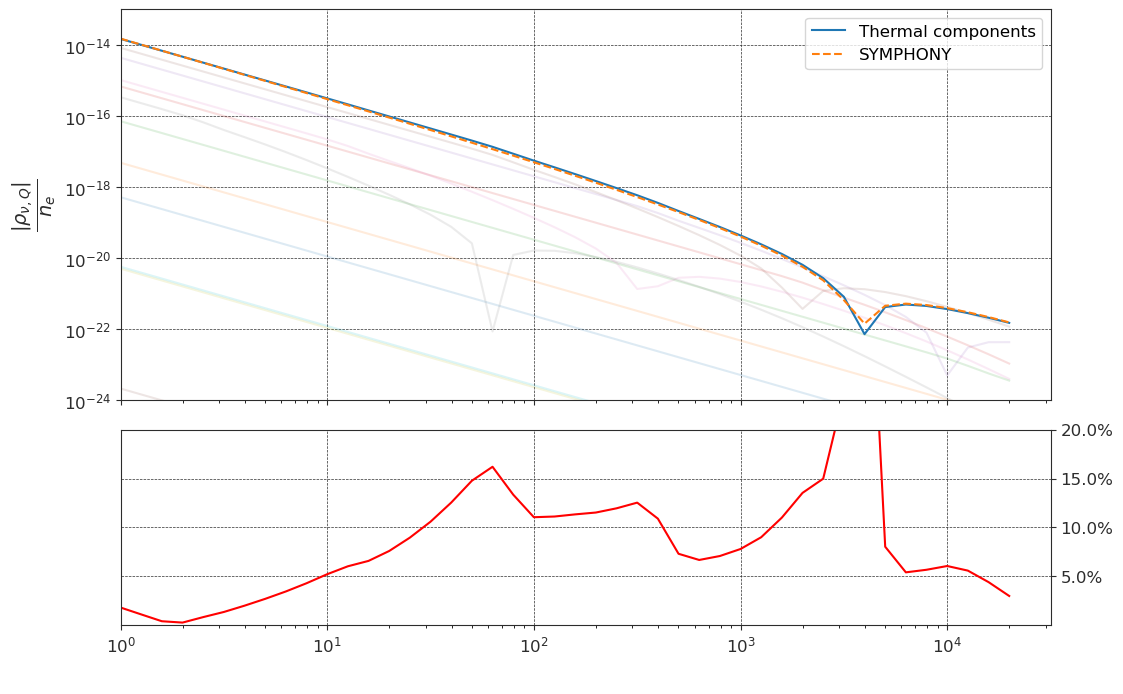

The median error: 7.450115380163556
49.32298492906644
0.2698451036133729


In [8]:
figure, ax = plt.subplots(2,1, figsize = (12,8),sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace':0.1})

# Start the timer
start_time = time.perf_counter()

"""Frequencies"""
# Define v_c
v_c = 0.84 * 10**8

# Generate the ratio v/v_c = [1, 10, 100, 1000, ...]
ratios = np.logspace(np.log10(1), np.log10(19952.620000), 44)  # This will generate [1, 10, 100, 1000, ...,]
"""
Note: The ratios seem very specific, this is the limit where Symphony produces a result in reasonable time.
To even get a little bit more than this, could take days to compute.
"""
# Calculate corresponding frequencies v = v_c * ratio
v = v_c * ratios

dv = np.diff(v/v_c)
dv = np.append(dv/v_c, dv[-1])

"""Lambda values"""
lam = np.logspace(-7, 0, N)

"""Compute Rotativity"""
# First normalize weights for comparison with Symphony
we_norm = weights/(np.sum(weights))

#Angle (60 Deg)
angle = (1/3)*np.pi

# End the timer
end_time = time.perf_counter()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time to calculate weights(incl. QP): {elapsed_time:.6f} seconds for N = {N}")

#Computes the total rotativity approximation
r_appr = np.zeros_like(v)
for i, w in zip(range(N), we_norm):
    r_i = w*rho_Q_th(n_e = 1, freq = v, freq_c = v_c, lam = lam[i], angle = angle)
    r_appr += r_i
    ax[0].loglog(v/v_c, np.abs(r_i) , alpha = 0.15)

"""Implement Symphony"""
# Load the CSV  for the rotativity data

# Use the path where this CSV file is stored
file_path = r"Insert your path here"
df = pd.read_csv(file_path)

# Rename columns if necessary
if "nu / nu_c" in df.columns:
    df.rename(columns={"nu / nu_c": "nu/nu_c"}, inplace=True)
r_symp = df["rho_Q"][:-1]

"""Plot parameters, and computing plots"""

ax[0].loglog(v/v_c, np.abs(r_appr), label = 'Thermal components')
ax[0].loglog(v/v_c, np.abs(r_symp), label="SYMPHONY", linestyle = 'dashed')

ax[0].set_ylim(10**-24, 10**-13)
ax[0].set_xlim(10**0, 10**9)
ax[0].set_ylabel(r'$\frac{|\rho_{\nu, Q}|}{n_e}$', fontsize=20, color='#2c2c2c')
ax[0].grid()
ax[0].legend(fontsize=12)

figure.patch.set_facecolor('white')  # Background for the figure

ax[0].set_facecolor('white')  # Background for the axes

# Customize the grid
ax[0].grid(color='#2c2c2c', linestyle='--', linewidth=0.5)
ax[0].spines['top'].set_color('#2c2c2c')    # Set the top spine color
ax[0].spines['bottom'].set_color('#2c2c2c')  # Set the bottom spine color
ax[0].spines['left'].set_color('#2c2c2c')  # Set the left spine color
ax[0].spines['right'].set_color('#2c2c2c') # Set the right spine color
# Customize ticks
ax[0].tick_params(axis='both', which='major', labelsize=12, colors='#2c2c2c')  # Adjust tick label font size and color


"""Compute the relative error"""
# Create a mask to identify non-zero elements in f_data
nzmask = f_data != 0

rel_error = np.abs((r_symp - r_appr) / (r_symp)) * 100

ax[1].plot(v/v_c, rel_error, color='red')

ax[1].set_xscale('log')
ax[1].set_xlim(1, 10**4.5)

# Set ylim to zoom in or out of the error plot
ax[1].set_ylim(10**-5, 2*10**1)

ax[1].yaxis.set_major_formatter(FuncFormatter(lambda rel_error, _: f'{rel_error:.1f}%'))
ax[1].yaxis.tick_right()

ax[1].set_xlabel(r'$\nu / \nu_c$', fontsize=15, color='white')
#ax[1].set_title("Relative error")
ax[1].grid()

ax[1].set_facecolor('white')  # Background for the axes

# Customize the grid
ax[1].grid(color='#2c2c2c', linestyle='--', linewidth=0.5)
ax[1].spines['top'].set_color('#2c2c2c')    # Set the top spine color
ax[1].spines['bottom'].set_color('#2c2c2c')  # Set the bottom spine color
ax[1].spines['left'].set_color('#2c2c2c')  # Set the left spine color
ax[1].spines['right'].set_color('#2c2c2c') # Set the right spine color
# Customize ticks
ax[1].tick_params(axis='both', which='major', labelsize=12, colors='#2c2c2c')  # Adjust tick label font size and color
plt.show()

print(f'The median error of this approximation is: {np.median(rel_error)}')
print(f'The max error of this approximation is: {np.max(rel_error)}')
print(f'The min error of this approximation is: {np.min(rel_error)}')